In [296]:
from analyticon_fifa.data_loader import MaleData, FemaleData
from analyticon_fifa.model import FIFAModel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind


In [297]:
maledf = MaleData()
femadf = FemaleData()
maledf["female"] = 0
femadf["female"] = 1
df = pd.concat((maledf, femadf), ignore_index=True)
df = df.sort_values(by=["sofifa_id", "year"])
df = df.drop_duplicates(subset=["sofifa_id"], keep="last")
df = df[df["pace"].notnull()].copy()

<Axes: ylabel='nationality_name'>

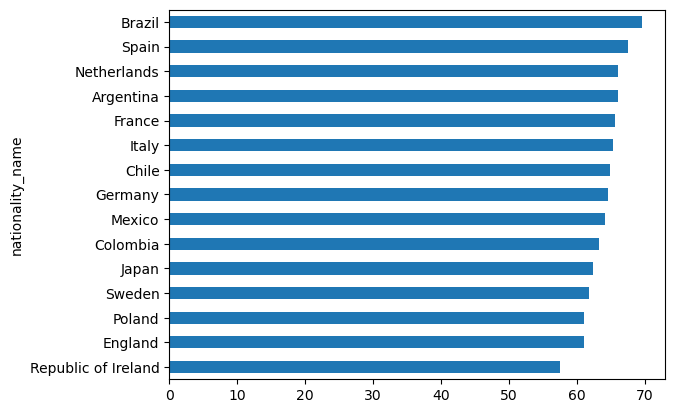

In [298]:
top10_countries = df.groupby("nationality_name")["sofifa_id"].count().nlargest(15)
df[df["nationality_name"].isin(top10_countries.index)].groupby("nationality_name")["overall"].mean().sort_values().plot(kind="barh")

<Axes: ylabel='nationality_name'>

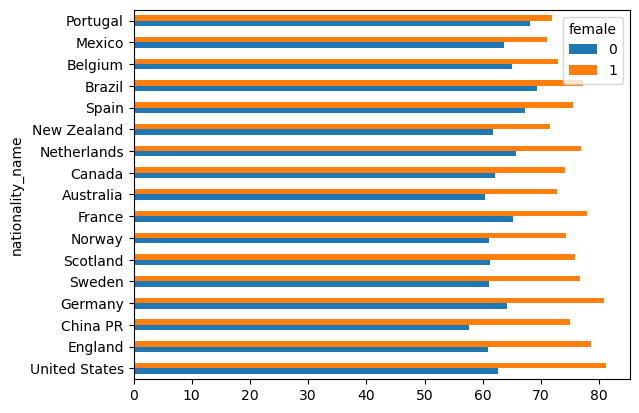

In [299]:
x = df.groupby(["nationality_name", "female"])["overall"].mean().unstack(1)
x = x[x[1].notnull()]
x["diff"] = x[1] - x[0]
x.sort_values(by="diff", inplace=True, ascending=False)
x[[0, 1,]].plot(kind="barh")

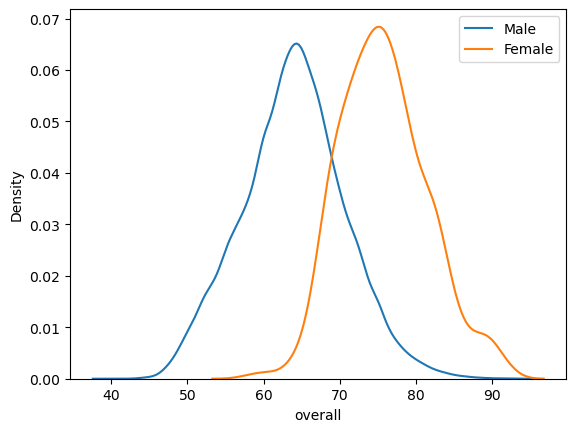

In [300]:
sns.kdeplot(data=df[df["female"] == 0], x="overall", label="Male")
sns.kdeplot(data=df[df["female"] == 1], x="overall", label="Female")
plt.legend()

In [301]:
ttest_ind(
    a=df[df["female"] == 0]["overall"],
    b=df[df["female"] == 1]["overall"],
    equal_var=False,
    alternative="two-sided"
)

TtestResult(statistic=-50.94964374950786, pvalue=6.359743483933657e-229, df=648.6055319390158)

<Axes: xlabel='age'>

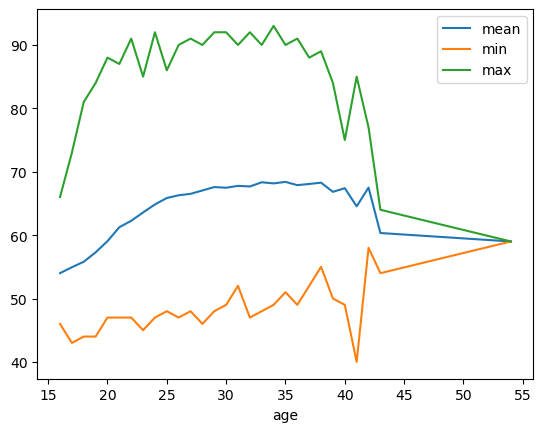

In [302]:
df.groupby("age").agg(mean=("overall", "mean"), min=("overall", "min"), max=("overall", "max")).plot()

In [303]:
model = FIFAModel.from_joblib()
df["value_eur_pred"] = model.predict(df)
df["value_us_pred"] = df["value_eur_pred"] * 1.1275 / 1000000
df["value_us"] = df["value_eur"] * 1.1275 / 1000000

<Axes: ylabel='nationality_name'>

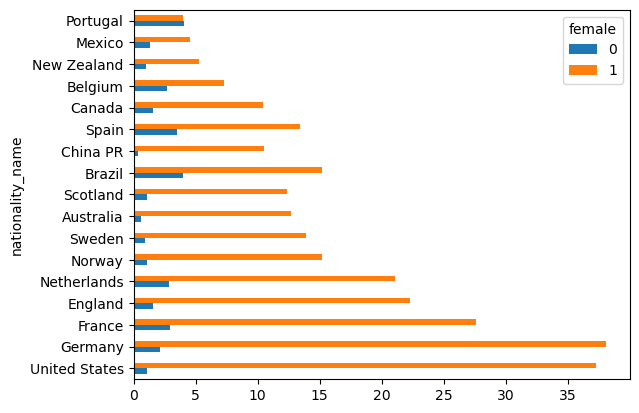

In [304]:
x = df.groupby(["nationality_name", "female"])["value_us_pred"].mean().unstack(1)
x = x[x[1].notnull()]
x["diff"] = x[1] - x[0]
x.sort_values(by="diff", inplace=True, ascending=False)
x[[0, 1,]].plot(kind="barh")

<Axes: xlabel='overall', ylabel='nationality_name'>

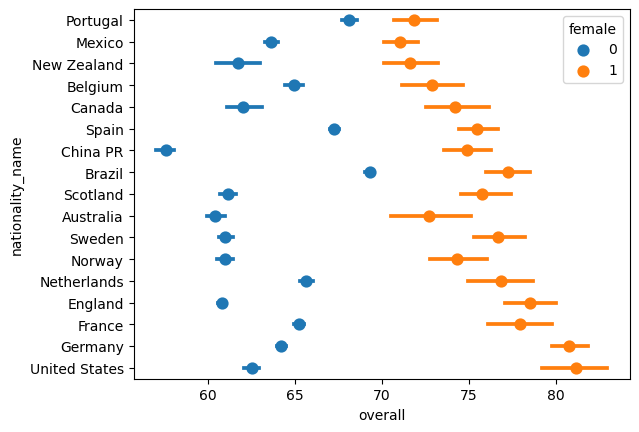

In [333]:
z = df.groupby("nationality_name")["female"].max()
sns.pointplot(
    data=df[df["nationality_name"].isin(z[z > 0].index)],
    x="overall",
    y="nationality_name",
    orient="h",
    hue="female",
    join=False,
    order=reversed(x.index)
)

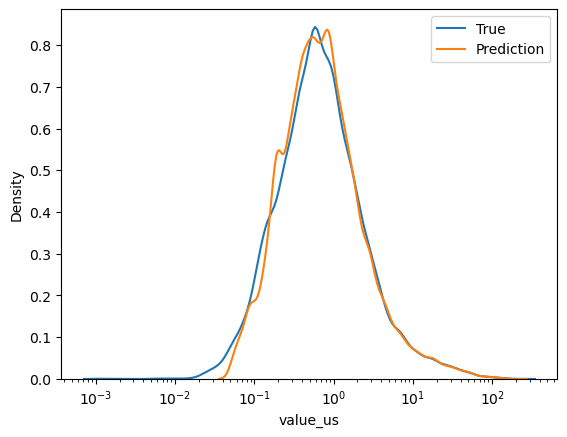

In [306]:
sns.kdeplot(data=df[df["value_us"].notnull()], x="value_us", label="True", log_scale=True)
sns.kdeplot(data=df[df["value_us"].notnull()], x="value_us_pred", label="Prediction", log_scale=True)
plt.legend()

In [307]:
ttest_ind(
    a=df[df["value_us"].notnull()]["value_us"],
    b=df[df["value_us"].notnull()]["value_us_pred"],
    equal_var=False,
    alternative="two-sided",
    nan_policy="omit"
)

TtestResult(statistic=0.02776804104454927, pvalue=0.9778472250548655, df=79871.7732447648)

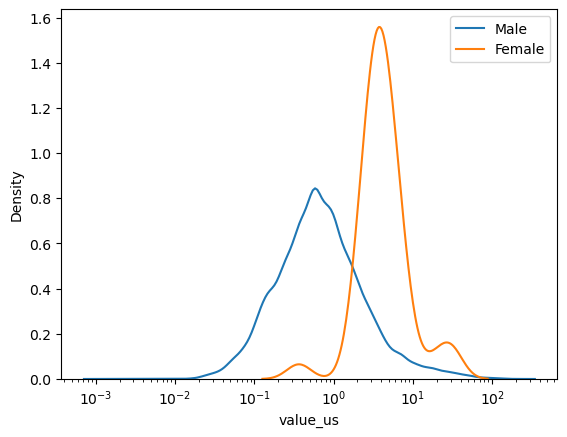

In [308]:
sns.kdeplot(data=df[df["female"] == 0], x="value_us", label="Male", log_scale=True)
sns.kdeplot(data=df[df["female"] == 1], x="value_us", label="Female", log_scale=True)
plt.legend()

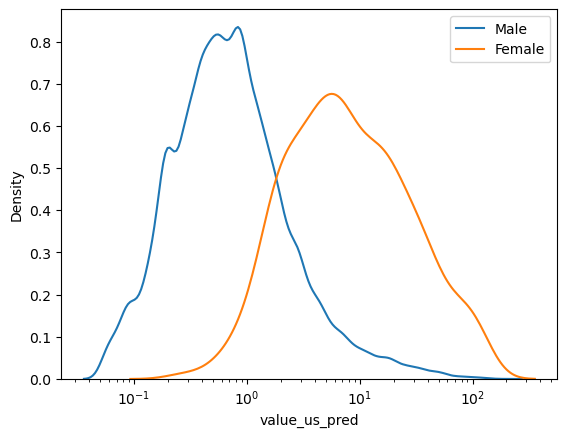

In [309]:
sns.kdeplot(data=df[df["female"] == 0], x="value_us_pred", label="Male", log_scale=True)
sns.kdeplot(data=df[df["female"] == 1], x="value_us_pred", label="Female", log_scale=True)
plt.legend()

In [310]:
ttest_ind(
    a=df[(df["value_us"].notnull()) & (df["female"] == 0)]["value_us_pred"],
    b=df[(df["value_us"].notnull()) & (df["female"] == 1)]["value_us_pred"],
    equal_var=False,
    alternative="two-sided",
    nan_policy="omit"
)

TtestResult(statistic=-3.795528926560193, pvalue=0.0005011637683943917, df=39.06810701980854)

In [311]:
df.groupby("female")["value_us_pred"].apply(lambda x: np.log(x).mean())

female
0   -0.338455
1    2.064530
Name: value_us_pred, dtype: float64

In [312]:
FEATURES = {
    "con": [
        "overall",
        "age",
        "height_cm",
        "weight_kg",
        "pace",
        "shooting",
        "passing",
        "dribbling",
        "defending",
        "physic",
        "attacking_crossing",
        "attacking_finishing",
        "attacking_heading_accuracy",
        "attacking_short_passing",
        "attacking_volleys",
        "skill_dribbling",
        "skill_curve",
        "skill_fk_accuracy",
        "skill_long_passing",
        "skill_ball_control",
        "movement_acceleration",
        "movement_sprint_speed",
        "movement_agility",
        "movement_reactions",
        "movement_balance",
        "power_shot_power",
        "power_jumping",
        "power_stamina",
        "power_strength",
        "power_long_shots",
        "mentality_aggression",
        "mentality_interceptions",
        "mentality_positioning",
        "mentality_vision",
        "mentality_penalties",
        "defending_marking_awareness",
        "defending_standing_tackle",
        "defending_sliding_tackle",
        "goalkeeping_diving",
        "goalkeeping_handling",
        "goalkeeping_kicking",
        "goalkeeping_positioning",
        "goalkeeping_reflexes",
    ],
    "cat": [
        "nationality_name",
        "female",
        "nation_position",
        "player_positions",
        "nation_jersey_number",
        "preferred_foot",
        "weak_foot",
        "skill_moves",
        "international_reputation",
        "work_rate",
        "body_type",
    ],
}
import statsmodels.api as sm
dfols = df[df["value_eur"].notnull()]
mod = sm.OLS(
    endog = dfols["value_us"],
    exog = dfols[["female"] + FEATURES["con"]],
)
res = mod.fit(cov_type="HC3", use_t=True)
print(res.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                                 OLS Regression Results                                
Dep. Variable:               value_us   R-squared (uncentered):                   0.373
Model:                            OLS   Adj. R-squared (uncentered):              0.372
Method:                 Least Squares   F-statistic:                              235.5
Date:                Sat, 19 Aug 2023   Prob (F-statistic):                        0.00
Time:                        23:37:25   Log-Likelihood:                     -1.2052e+05
No. Observations:               39951   AIC:                                  2.411e+05
Df Residuals:                   39907   BIC:                                  2.415e+05
Df Model:                          44         

In [313]:
df.nlargest(10, "value_us")[["long_name", "value_us", "female"]]

,long_name,value_us,female
6,Kylian Mbappé Lottin,218.73500,0
29,Erling Braut Haaland,155.03125,0
9,Harry Kane,146.01125,0
3,Neymar da Silva Santos Júnior,145.44750,0
4,Kevin De Bruyne,141.50125,0
1,Robert Lewandowski,134.73625,0
43,Frenkie de Jong,134.73625,0
45,Jadon Sancho,131.35375,0
44,Trent Alexander-Arnold,128.53500,0
19,Joshua Walter Kimmich,121.77000,0


In [314]:
df.nlargest(10, "value_us_pred")[["long_name", "value_us_pred", "female"]]

,long_name,value_us_pred,female
6,Kylian Mbappé Lottin,177.026269,0
3,Neymar da Silva Santos Júnior,137.286279,0
9,Harry Kane,135.074500,0
29,Erling Braut Haaland,134.736250,0
4,Kevin De Bruyne,133.467813,0
43,Frenkie de Jong,130.522621,0
142771,Vivianne Miedema,127.024150,1
45,Jadon Sancho,126.501106,0
142774,Dzsenifer Marozsán,125.919200,1
44,Trent Alexander-Arnold,125.084850,0


<Axes: xlabel='overall', ylabel='value_us'>

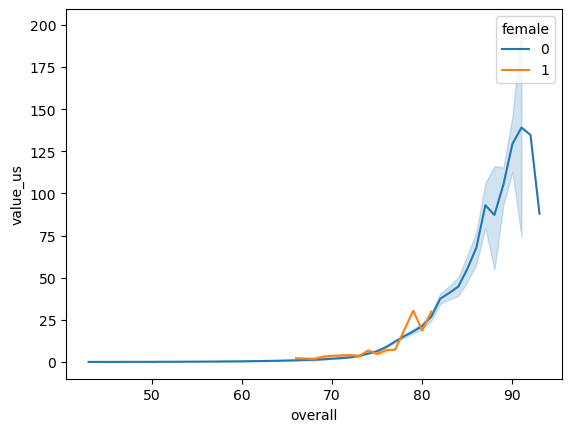

In [315]:
sns.lineplot(data=df, x="overall", y="value_us", hue="female")

In [326]:
df["value_us_pred_perc"] = df.groupby("female")["value_us_pred"].rank(pct=True)
df["overall_perc"] = df.groupby("female")["overall"].rank(pct=True)

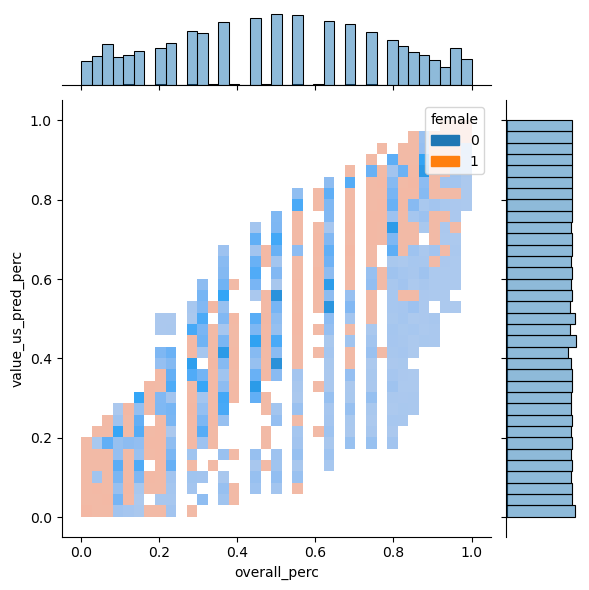

In [327]:
sns.jointplot(data=df, x="overall_perc", y="value_us_pred_perc", hue="female", kind="hist")

In [328]:
df["perc_diff"] = df["overall_perc"] - df["value_us_pred_perc"]

<Axes: xlabel='perc_diff', ylabel='Density'>

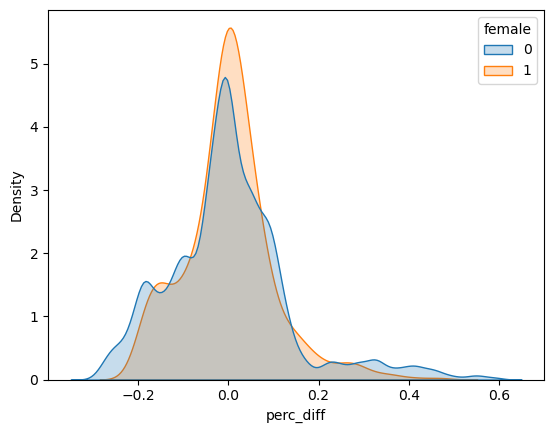

In [329]:
sns.kdeplot(data=df, x="perc_diff", hue="female", common_norm=False, fill=True)

In [330]:
df["over_half"] = df["perc_diff"] > 0

In [331]:
df.nlargest(n=10, columns="overall")[["long_name", "overall_perc", "value_us_pred_perc", "perc_diff", "over_half"]]

,long_name,overall_perc,value_us_pred_perc,perc_diff,over_half
0,Lionel Andrés Messi Cuccittini,1.000000,0.999358,0.000642,True
1,Robert Lewandowski,0.999975,0.999729,0.000247,True
142769,Lucia Roberta Tough Bronze,0.998395,0.990369,0.008026,True
142770,Wéndèleine Thérèse Renard,0.998395,0.985554,0.012841,True
142771,Vivianne Miedema,0.998395,1.000000,-0.001605,False
2,Cristiano Ronaldo dos Santos Aveiro,0.999914,0.998742,0.001172,True
3,Neymar da Silva Santos Júnior,0.999914,0.999975,-0.000062,False
4,Kevin De Bruyne,0.999914,0.999901,0.000012,True
142772,Samantha May Kerr,0.995185,0.991974,0.003210,True
6,Kylian Mbappé Lottin,0.999914,1.000000,-0.000086,False


In [332]:
df.groupby("female")["over_half"].mean()

female
0    0.459631
1    0.499197
Name: over_half, dtype: float64